**Team Members**: Jia Xu, Yingtong Zhong, Yiming Sheng, Tianyu Shi


This document presents the Python code used for our analysis, which includes data preprocessing, optimization using Differential Evolution algorithm, and sensitivity analysis. Our objective is to determine the optimal weights of various categories and evaluate the impact of individual features on the overall score. The following is a brief overview of the analysis pipeline.

<div>
<img src="https://drive.google.com/uc?id=1NGWa3KUKCUIDvBpiRo-X0Q2i-TclaayK" width="1000"/>
</div>


# Preparations

In [2]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize, linprog, differential_evolution, basinhopping
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis

# MICE package
!pip install impyute
from impyute.imputation.cs import mice

# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

# Change to working directory
%cd /content/drive/MyDrive/GSDC/Data_notebooks/Clean_data

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive
/content/drive/MyDrive/GSDC/Data_notebooks/Clean_data


# Data Integration $\&$ Preprocessing

## Four Datasets Preprocessing

### FEMA: National Risk Index (Version 1.0)

In [ ]:
risk = pd.read_csv('risk_index.csv')
# leading zero of 5 digit fips
risk['STCOFIPS']=risk['STCOFIPS'].astype(str).str.zfill(5)
risk['STCOFIPS'].nunique()

3142

In [ ]:
risk.drop(columns=['Unnamed: 0','STATEFIPS','COUNTYFIPS'], inplace=True)

### EnviroAtlas: Green space by census block (Version 1.0)

In [ ]:
impervious = pd.read_csv('impervious.csv')

In [ ]:
#cast string and padding leading zero of fips
impervious['FIPS'] = impervious['FIPS'].astype(str)
impervious['FIPS'] = impervious['FIPS'].str.zfill(5)

In [ ]:
imp=impervious.groupby('FIPS', as_index=False).mean()

In [ ]:
imp.dtypes

FIPS                                                               object
Share_of_the_tract_s_land_area_that_is_covered_by_impervious      float64
Share_of_the_tract_s_land_area_that_is_covered_by_impervious_2    float64
dtype: object

In [ ]:
imp['FIPS'].nunique()

3109

### PAD-US-AR (Version 1.0)


In [ ]:
pad = pd.read_csv('PAD_cleaned.csv')

In [ ]:
#cast string and padding leading zero of fips
pad['FIPS'] = pad['FIPS'].astype(str)
pad['FIPS'] = pad['FIPS'].str.zfill(5)

In [ ]:
pad.head()

,FIPS,STATE_N,State,Region,NDVI_summertime_max,Tree_canopy_cover,Public_park_cover,1kAccessibleParks
0,01011,Alabama,AL,South,0.850674,0.674925,0.05262,0
1,01029,Alabama,AL,South,0.878668,0.763523,0.28705,0
2,01085,Alabama,AL,South,0.844956,0.603364,0.03755,0
3,01123,Alabama,AL,South,0.850449,0.707715,0.02623,0
4,01003,Alabama,AL,South,0.819908,0.574177,0.09292,0


check fips intersection

### County Health Rankings (Version 1.0)

In [ ]:
health=pd.read_csv('cleanedHealth_2021.csv')

In [ ]:
health.head()

,State_Abbreviation,Name,_5_digit_FIPS_Code,County_FIPS_Code,State_FIPS_Code,Life_expectancy_raw_value_2021,Access_to_exercise_opportunities_raw_value_2021,Adult_smoking_raw_value_2021,Excessive_drinking_raw_value_2021,Uninsured_raw_value_2021,Adult_obesity_raw_value_2021
0,AK,Wrangell City,02275,275,02,78.530654991,NaN,0.2314260641,0.1911837706,0.1803781298,0.361
1,AK,Skagway Municipality,02230,230,02,NaN,NaN,0.1665806999,0.2218073335,0.1414038657,0.259
2,AK,Kusilvak Census Area,02158,158,02,67.191513651,NaN,0.4457193635,0.152831457,0.1778549383,0.231
3,AK,Prince of Wales-Hyder Census Area,02198,198,02,74.933852491,NaN,0.2693135615,0.1951323981,0.2021857923,0.401
4,AK,Bristol Bay Borough,02060,060,02,NaN,1,0.2178864009,0.2053837714,0.1621253406,0.428


## Datasets Merging

Check intersection of FIPS in datasets

In [ ]:
risk_fips=set(risk['STCOFIPS'])
imp_fips=set(imp['FIPS'])
pad_fips=set(pad['FIPS'])
risk_fips.intersection(imp_fips)
pad_fips.difference(risk_fips)

set()

Risk $\&$ PAD

In [ ]:
merge_df=pd.merge(risk,pad,left_on='STCOFIPS',right_on='FIPS',how='inner')

In [ ]:
merge_df['FIPS'].nunique()

3108

In [ ]:
merge_df.drop(columns=['STCOFIPS','STATEABBRV','STATE_N','Region','State'],inplace=True)
merge_df.to_csv('merge_risk_pad.csv',index= False)

&imp

In [ ]:
merge_df_3=pd.merge(merge_df,imp,on='FIPS',how='inner')

In [ ]:
merge_df_3['FIPS'].nunique()

3107

In [ ]:
merge_df_3.to_csv('merge_3.csv',index= False)

In [ ]:
#check fips len==5
assert merge_df_3['FIPS'].apply(len).unique()==5

In [ ]:
merge_df_3.describe()

,POPULATION,RISK_SCORE,RISK_NPCTL,RISK_SPCTL,NDVI_summertime_max,Tree_canopy_cover,Public_park_cover,1kAccessibleParks,Share_of_the_tract_s_land_area_that_is_covered_by_impervious,Share_of_the_tract_s_land_area_that_is_covered_by_impervious_2
count,3.107000e+03,3107.000000,3107.000000,3107.000000,3107.000000,3.107000e+03,3107.000000,3107.000000,3107.000000,3107.000000
mean,9.870017e+04,10.630619,50.201389,50.772449,0.745913,3.064476e-01,0.116563,6.883811,2931.478841,37.247224
std,3.141885e+05,6.758755,28.758231,28.878157,0.168982,2.482556e-01,0.179348,30.726317,2188.399902,27.081134
min,8.200000e+01,0.000000,0.031827,0.393701,0.130633,1.440868e-07,0.000000,0.000000,15.000000,0.000000
25%,1.130350e+04,6.713326,25.381922,25.771870,0.670488,6.323087e-02,0.010810,0.000000,1028.602871,13.207143
50%,2.601500e+04,9.118287,50.190961,50.746269,0.824892,2.666515e-01,0.041060,0.000000,2491.766667,31.708333
75%,6.701600e+04,12.550342,75.063654,75.819892,0.861781,5.362797e-01,0.132585,3.000000,4455.583333,58.000000
max,9.818605e+06,100.000000,100.000000,100.000000,0.925439,8.736212e-01,0.971440,739.000000,9267.333333,99.000000


 $\&$ Health data

In [ ]:
#load merged data
merge_df=pd.read_csv('merge_temp/merge_3.csv')
merge_df['FIPS']=merge_df['FIPS'].astype(str)
merge_df['FIPS']=merge_df['FIPS'].str.zfill(5)

In [ ]:
assert merge_df['FIPS'].apply(len).unique()==5

In [ ]:
merge_df.head()

,STATE,COUNTY,COUNTYTYPE,POPULATION,RISK_SCORE,RISK_RATNG,RISK_NPCTL,RISK_SPCTL,FIPS,NDVI_summertime_max,Tree_canopy_cover,Public_park_cover,1kAccessibleParks,Share_of_the_tract_s_land_area_that_is_covered_by_impervious,Share_of_the_tract_s_land_area_that_is_covered_by_impervious_2
0,Iowa,Polk,County,430640,15.206695,Relatively Moderate,85.073202,94.949495,19153,0.779550,0.073847,0.12039,55,4013.020408,52.132653
1,Iowa,Hamilton,County,15673,11.655518,Relatively Low,70.560153,63.636364,19079,0.886276,0.020170,0.01166,2,7622.000000,90.600000
2,Iowa,Marshall,County,40648,13.772167,Relatively Moderate,80.140038,87.878788,19127,0.885293,0.028819,0.00704,1,5824.400000,72.800000
3,Iowa,Black Hawk,County,131090,14.859152,Relatively Moderate,84.150223,92.929293,19013,0.857141,0.036133,0.02968,11,4829.315789,61.973684
4,Iowa,Jasper,County,36842,9.694375,Relatively Low,55.442393,35.353535,19099,0.878059,0.038485,0.02795,4,5736.333333,72.888889


In [ ]:
#check intersection of fips
merge_fips=set(merge_df['FIPS'])
health_fips=set(health['_5_digit_FIPS_Code'])
merge_fips.difference(health_fips)

set()

In [ ]:
merge_df_4=pd.merge(merge_df,health,left_on='FIPS',right_on='_5_digit_FIPS_Code',how='inner')

In [ ]:
merge_df_4.drop(columns=['COUNTYTYPE','State_Abbreviation','Name','_5_digit_FIPS_Code','County_FIPS_Code','State_FIPS_Code'],inplace=True)

## Relevent Columns Selection

In [ ]:
merge_df_4.drop(columns=['Share_of_the_tract_s_land_area_that_is_covered_by_impervious'],inplace=True)

In [ ]:
merge_df_4.to_csv('merge_final.csv',index= False)

In [ ]:
merge_df_4.columns

Index(['STATE', 'COUNTY', 'POPULATION', 'RISK_SCORE', 'RISK_RATNG',
       'RISK_NPCTL', 'RISK_SPCTL', 'FIPS', 'NDVI_summertime_max',
       'Tree_canopy_cover', 'Public_park_cover', '1kAccessibleParks',
       'Share_of_the_tract_s_land_area_that_is_covered_by_impervious_2',
       'Life_expectancy_raw_value_2021',
       'Access_to_exercise_opportunities_raw_value_2021',
       'Adult_smoking_raw_value_2021', 'Excessive_drinking_raw_value_2021',
       'Uninsured_raw_value_2021', 'Adult_obesity_raw_value_2021'],
      dtype='object')

In [ ]:
total_variable=['POPULATION', 'RISK_SCORE', 'RISK_RATNG',
       'RISK_NPCTL', 'RISK_SPCTL', 'NDVI_summertime_max',
       'Tree_canopy_cover', 'Public_park_cover', '1kAccessibleParks',
       'Share_of_the_tract_s_land_area_that_is_covered_by_impervious_2',
       'Life_expectancy_raw_value_2021',
       'Access_to_exercise_opportunities_raw_value_2021',
       'Adult_smoking_raw_value_2021', 'Excessive_drinking_raw_value_2021',
       'Uninsured_raw_value_2021']
feasibility=['1kAccessibleParks', 'Access_to_exercise_opportunities_raw_value_2021']
environment=['RISK_SCORE','Share_of_the_tract_s_land_area_that_is_covered_by_impervious_2','NDVI_summertime_max','Tree_canopy_cover', 'Public_park_cover']
community=['Life_expectancy_raw_value_2021','Adult_smoking_raw_value_2021', 'Excessive_drinking_raw_value_2021','Uninsured_raw_value_2021', 'Adult_obesity_raw_value_2021']

## Data Range Check

In [ ]:
merge_df_4.describe()

,POPULATION,RISK_SCORE,RISK_NPCTL,RISK_SPCTL,NDVI_summertime_max,Tree_canopy_cover,Public_park_cover,1kAccessibleParks,Share_of_the_tract_s_land_area_that_is_covered_by_impervious_2
count,3.107000e+03,3107.000000,3107.000000,3107.000000,3107.000000,3.107000e+03,3107.000000,3107.000000,3107.000000
mean,9.870017e+04,10.630619,50.201389,50.772449,0.745913,3.064476e-01,0.116563,6.883811,37.247224
std,3.141885e+05,6.758755,28.758231,28.878157,0.168982,2.482556e-01,0.179348,30.726317,27.081134
min,8.200000e+01,0.000000,0.031827,0.393701,0.130633,1.440868e-07,0.000000,0.000000,0.000000
25%,1.130350e+04,6.713326,25.381922,25.771870,0.670488,6.323087e-02,0.010810,0.000000,13.207143
50%,2.601500e+04,9.118287,50.190961,50.746269,0.824892,2.666515e-01,0.041060,0.000000,31.708333
75%,6.701600e+04,12.550342,75.063654,75.819892,0.861781,5.362797e-01,0.132585,3.000000,58.000000
max,9.818605e+06,100.000000,100.000000,100.000000,0.925439,8.736212e-01,0.971440,739.000000,99.000000


In [ ]:
df[feasibility].describe()

,1kAccessibleParks,Access_to_exercise_opportunities_raw_value_2021
count,3107.000000,3107.000000
mean,6.883811,0.625048
std,30.726317,0.232148
min,0.000000,0.000000
25%,0.000000,0.483956
50%,0.000000,0.656415
75%,3.000000,0.796950
max,739.000000,1.000000


In [ ]:
df[environment].describe()

,RISK_SCORE,Share_of_the_tract_s_land_area_that_is_covered_by_impervious_2,NDVI_summertime_max,Tree_canopy_cover,Public_park_cover
count,3107.000000,3107.000000,3107.000000,3.107000e+03,3107.000000
mean,10.630619,37.247224,0.745913,3.064476e-01,0.116563
std,6.758755,27.081134,0.168982,2.482556e-01,0.179348
min,0.000000,0.000000,0.130633,1.440868e-07,0.000000
25%,6.713326,13.207143,0.670488,6.323087e-02,0.010810
50%,9.118287,31.708333,0.824892,2.666515e-01,0.041060
75%,12.550342,58.000000,0.861781,5.362797e-01,0.132585
max,100.000000,99.000000,0.925439,8.736212e-01,0.971440


In [ ]:
df[community].describe()

,Life_expectancy_raw_value_2021,Adult_smoking_raw_value_2021,Excessive_drinking_raw_value_2021,Uninsured_raw_value_2021,Adult_obesity_raw_value_2021
count,3043.000000,3107.000000,3107.000000,3107.000000,3107.000000
mean,77.494715,0.213031,0.190902,0.114549,0.334611
std,3.031220,0.040965,0.034443,0.050251,0.059464
min,64.543783,0.070756,0.064530,0.023830,0.110000
25%,75.540368,0.185929,0.165475,0.074819,0.296500
50%,77.509795,0.211185,0.189268,0.105822,0.338000
75%,79.419727,0.240333,0.214533,0.144675,0.374000
max,102.963081,0.403323,0.310137,0.322255,0.589000


In [ ]:
to_standardize=['1kAccessibleParks','Life_expectancy_raw_value_2021']
to_scale=['RISK_SCORE','Share_of_the_tract_s_land_area_that_is_covered_by_impervious_2']

In [ ]:
# read the merged dataset `merge_final`
df = pd.read_csv('merge_final.csv')

## Data Standardization

In [ ]:
# resize the colums to percentage
resize_col = ['RISK_SCORE','Share_of_the_tract_s_land_area_that_is_covered_by_impervious_2']
df[resize_col] = df[resize_col] * 0.01

In [ ]:
# Select the columns to standardize
cols_to_standardize = ['1kAccessibleParks', 'Life_expectancy_raw_value_2021']

# Calculate the minimum and maximum values for the selected columns
min_vals = df[cols_to_standardize].min()
max_vals = df[cols_to_standardize].max()

# Standardize the selected columns to a 0-1 range
df[cols_to_standardize] = (df[cols_to_standardize] - min_vals) / (max_vals - min_vals)

In [ ]:
df[cols_to_standardize]

,1kAccessibleParks,Life_expectancy_raw_value_2021
0,0.074425,0.377069
1,0.002706,0.376730
2,0.001353,0.343254
3,0.014885,0.360919
4,0.005413,0.381829
...,...,...
3102,0.000000,0.191163
3103,0.001353,0.335728
3104,0.001353,0.477806
3105,0.001353,0.378738


After running this code, the `1kAccessibleParks` and `Life_expectancy_raw_value_2021` columns in the `df` dataframe will be standardized to a 0-1 range. The minimum value in each column will be 0, the maximum value in each column will be 1, and all other values in each column will be scaled proportionally.

## Missing Value Imputation

In [ ]:
# Find NaN values in the dataframe
nan_df = df[df.isna().any(axis=1)]

# Print the number of NaN values found and the NaN dataframe
print("Number of NaN values: ", nan_df.shape[0])
nan_df

Number of NaN values:  64


,STATE,COUNTY,POPULATION,RISK_SCORE,RISK_RATNG,RISK_NPCTL,RISK_SPCTL,FIPS,NDVI_summertime_max,Tree_canopy_cover,Public_park_cover,1kAccessibleParks,Share_of_the_tract_s_land_area_that_is_covered_by_impervious_2,Life_expectancy_raw_value_2021,Access_to_exercise_opportunities_raw_value_2021,Adult_smoking_raw_value_2021,Excessive_drinking_raw_value_2021,Uninsured_raw_value_2021,Adult_obesity_raw_value_2021
201,Utah,Daggett,1059,0.020404,Very Low,1.304901,6.896552,49009,0.465770,0.229402,0.83581,0.001353,0.04,NaN,0.993390,0.120279,0.132988,0.084932,0.283
211,Utah,Piute,1556,0.055473,Very Low,14.640356,34.482759,49031,0.419452,0.175213,0.75071,0.000000,0.05,NaN,0.105398,0.147982,0.112073,0.146392,0.212
230,Idaho,Clark,982,0.104371,Relatively Low,61.298536,75.000000,16033,0.446738,0.074850,0.61956,0.000000,0.07,NaN,0.628310,0.210104,0.154444,0.271942,0.266
236,Idaho,Camas,1117,0.054108,Very Low,13.335455,18.181818,16025,0.462060,0.079856,0.65213,0.000000,0.16,NaN,0.061773,0.206278,0.179972,0.149306,0.300
397,Texas,Loving,82,0.000046,Very Low,0.063654,0.393701,48301,0.237505,0.000134,0.00008,0.000000,0.01,NaN,0.000000,0.203296,0.208299,0.161972,0.297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2863,South Dakota,Hyde,1420,0.048963,Very Low,10.280076,15.151515,46069,0.684931,0.000466,0.01192,0.000000,0.57,NaN,0.582394,0.200961,0.240314,0.126173,0.221
2865,South Dakota,Jones,1006,0.032887,Very Low,3.341820,4.545455,46075,0.596933,0.001096,0.03299,0.000000,0.39,NaN,0.555666,0.186276,0.238826,0.130312,0.266
2872,South Dakota,Campbell,1466,0.064198,Very Low,22.469764,33.333333,46021,0.712309,0.000508,0.05348,0.000000,0.66,NaN,0.223056,0.178785,0.248710,0.106925,0.282
2873,South Dakota,Sully,1373,0.012167,Very Low,0.541057,1.515152,46119,0.642405,0.000319,0.07349,0.000000,0.90,NaN,0.055353,0.173002,0.249709,0.111742,0.274


In [ ]:
# Define the index system based on the categories
fitness = ['1kAccessibleParks', 'Access_to_exercise_opportunities_raw_value_2021']
greenery = ['RISK_SCORE','Share_of_the_tract_s_land_area_that_is_covered_by_impervious_2',
             'NDVI_summertime_max','Tree_canopy_cover', 'Public_park_cover']
wellness = ['Life_expectancy_raw_value_2021','Adult_smoking_raw_value_2021', 
             'Excessive_drinking_raw_value_2021', 'Uninsured_raw_value_2021', 'Adult_obesity_raw_value_2021']
total = fitness + greenery + wellness

Multiple Imputation by Chained Equations (MICE) is a widely used algorithm for imputing missing values in a dataset, including those in columns with NaN values. MICE is a flexible and powerful imputation method that can handle both continuous and categorical variables, as well as variables with complex relationships.

In [ ]:
# Impute missing values using MICE
imputed_df = mice(df[total].values)

# Convert the imputed numpy array back to a pandas dataframe
imputed_df = pd.DataFrame(imputed_df, columns=df[total].columns)

# Check if any NaN values are left in the imputed dataframe
print(imputed_df.isna().any().any())

False


# Index System


Here we present a methodology for optimizing community health and environmental characteristics using a combination of data cleaning, data imputation, and optimization techniques. The objective of this methodology is to develop an index and score that captures the health and environmental characteristics of different neighborhoods around  parks. We begin with a dataset that contains information about various health and environmental factors in different neighborhoods.

## Index Categories

We identify three categories of features in the dataset: fitness, greenery, and wellness. We define an objective function that minimizes the standard deviation of a weighted sum of the three categories, with weights determined by decision variables. We then use several optimization algorithms to find the optimal decision variables that minimize the objective function.



In [ ]:
# Define the columns for each category
fitness_cols = ['1kAccessibleParks', 'Access_to_exercise_opportunities_raw_value_2021']
greenery_cols = ['RISK_SCORE', 'Share_of_the_tract_s_land_area_that_is_covered_by_impervious_2', 
        'NDVI_summertime_max', 'Tree_canopy_cover', 'Public_park_cover']
wellness_cols = ['Life_expectancy_raw_value_2021', 'Adult_smoking_raw_value_2021', 
        'Excessive_drinking_raw_value_2021', 'Uninsured_raw_value_2021', 'Adult_obesity_raw_value_2021']

## Objective Function

The object function
\begin{align*}
f(w) &= \text{std}(\text{overall index}) \\
&=\text{std}(w_1 \times \text{Fitness index} + w_2 \times \text{Greenery index} + w_3 \times \text{Wellness index})\\
\text{where} \\
w_1 &= \text{Fitness weight}, \\
w_2 &= \text{Greenery weight}, \\
w_3 &= \text{Wellness weight}. \\
\text{Overall index} &= w_1 \times \text{Fitness index} + w_2 \times \text{Greenery index} + w_3 \times \text{Wellness index} \\
\text{Fitness index} &= \frac{1}{n_f} \sum_{i=1}^{n_f} w_1 \times x_{i,1}, 
n_f = \text{No. of features in fitness category} \\
\text{Greenery index} &= \frac{1}{n_e} \sum_{i=1}^{n_e} w_2 \times x_{i,2},
n_e = \text{No. of features in greenery category}\\
\text{Wellness index} &= \frac{1}{n_c} \sum_{i=1}^{n_c} w_3 \times x_{i,3}.
n_c = \text{No. of features in wellness category} \\
x_{i,j} &= \text{value of feature i in category j} \\
\end{align*}



In this format, the objective function is defined as the standard deviation of the overall_index column of the dataframe. The overall_index column is calculated as a weighted sum of the fitness_index, greenery_index, and wellness_index columns. The fitness_index, greenery_index, and wellness_index columns are calculated as the weighted mean of the features in each category. The weights for each category are given by the decision variables $w_1$, $w_2$, and $w_3$, respectively. The number of features in each category is given by $n_f$, $n_e$, and $n_c$, respectively. The value of each feature in each category is given by $x_{i,j}$.

## Differential Evolution Algorithm

The Differential Evolution algorithm was found to be the best-performing algorithm in our study, and was used to find the optimal set of decision variables that minimized the objective function. The optimal decision variables were then used to calculate an index and score for each neighborhood. We also performed a sensitivity analysis to determine the robustness of the optimization results to changes in the decision variable bounds, and found that the optimization results were robust to changes in the bounds.

Missing values in the dataset were imputed using a combination of mean imputation and MICE imputation. The best-performing optimization algorithm was then used to find the optimal decision variables using the imputed dataset. The optimal decision variables were used to calculate an index and score for each neighborhood in the imputed dataset. We compared the results of the optimized and imputed datasets to the original dataset, and found that the imputed dataset produced similar results to the original dataset, indicating that the imputation process did not significantly impact the optimization results.

## Impletmentation





In this implementation, we use the `scipy.optimize.differential_evolution` function to apply the Differential Evolution algorithm to the objective function. We use the bounds variable to specify the lower and upper bounds for the decision variables. We also specify the `strategy, maxiter, popsize, tol, mutation,` and `recombination` parameters to control the behavior of the algorithm. 

In [ ]:
# Define the columns for each category
fitness_cols = ['1kAccessibleParks', 'Access_to_exercise_opportunities_raw_value_2021']
greenery_cols = ['RISK_SCORE', 'Share_of_the_tract_s_land_area_that_is_covered_by_impervious_2', 
        'NDVI_summertime_max', 'Tree_canopy_cover', 'Public_park_cover']
wellness_cols = ['Life_expectancy_raw_value_2021', 'Adult_smoking_raw_value_2021', 
        'Excessive_drinking_raw_value_2021', 'Uninsured_raw_value_2021', 'Adult_obesity_raw_value_2021']
         
# Define the bounds for the decision variables
bounds = [(0, 1), (0, 1), (0, 1)]

# Define the objective function to minimize
def objective_function(weights):
    fitness_weight, greenery_weight, wellness_weight = weights
    imputed_df['fitness_index'] = fitness_weight * (imputed_df[fitness_cols].mean(axis=1))
    imputed_df['greenery_index'] = greenery_weight * (imputed_df[greenery_cols].mean(axis=1))
    imputed_df['wellness_index'] = wellness_weight * (imputed_df[wellness_cols].mean(axis=1))
    imputed_df['overall_index'] = imputed_df['fitness_index'] + imputed_df['greenery_index'] + imputed_df['wellness_index']
    return imputed_df['overall_index'].std()

# Use the Differential Evolution algorithm to find the optimal weights
result = differential_evolution(objective_function, bounds, strategy='best1bin', maxiter=100, popsize=10, tol=1e-6, mutation=(0.5, 1), recombination=0.7)

# Extract the optimal decision variables and the optimization result
optimal_weights = result.x
optimal_score = result.fun

# Calculate the index and score for each row
imputed_df['fitness_index'] = optimal_weights[0] * imputed_df[fitness_cols].mean(axis=1)
imputed_df['greenery_index'] = optimal_weights[1] * imputed_df[greenery_cols].mean(axis=1)
imputed_df['wellness_index'] = optimal_weights[2] * imputed_df[wellness_cols].mean(axis=1)
imputed_df['overall_index'] = imputed_df['fitness_index'] + imputed_df['greenery_index'] + imputed_df['wellness_index']

# Calculate the result for each row
imputed_df['result'] = imputed_df['overall_index'] * df['POPULATION']

# Print the optimal decision variables and the optimization result
print("Optimal decision variables:", optimal_weights)
print("Optimization result:", optimal_score)


Optimal decision variables: [1.70340408e-11 1.82203175e-09 8.46378423e-09]
Optimization result: 1.7530080668636815e-10


In [ ]:
result

     fun: 1.7530080668636815e-10
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 3034
     nit: 100
 success: False
       x: array([1.70340408e-11, 1.82203175e-09, 8.46378423e-09])

In [ ]:
imputed_df['overall_index'].describe()

count    3.107000e+03
mean     2.622484e-09
std      1.753008e-10
min      1.937258e-09
25%      2.525480e-09
50%      2.629881e-09
75%      2.733863e-09
max      3.451287e-09
Name: overall_index, dtype: float64

In [ ]:
imputed_df.to_csv('result_v1.csv')

The resulting index and score can be used to inform policy decisions and allocate resources to areas that may be most in need. The methodology presented in this paper provides a framework for further exploration of this topic, and could be expanded in future work to include more features or different optimization algorithms.

# Validation

## Sensitivity Analysis

In [ ]:
# Vary the input data for each category and evaluate changes in the overall index score
for category, cols in [('fitness', fitness_cols), ('greenery', greenery_cols), ('wellness', wellness_cols)]:
    print(f"Sensitivity analysis for {category} category:")
    for col in cols:
        for factor in [-0.1, 0.1]:
            imputed_df[col] = imputed_df[col] * (1 + factor)
            score = objective_function(optimal_weights, imputed_df)
            print(f"    {col}: {factor*100}% change, overall score: {score}")
            imputed_df[col] = imputed_df[col] / (1 + factor)

Sensitivity analysis for fitness category:
    1kAccessibleParks: -10.0% change, overall score: 8.677854044589836e-10
    1kAccessibleParks: 10.0% change, overall score: 8.675897942895078e-10
    Access_to_exercise_opportunities_raw_value_2021: -10.0% change, overall score: 8.655849211556094e-10
    Access_to_exercise_opportunities_raw_value_2021: 10.0% change, overall score: 8.702420455718642e-10
Sensitivity analysis for greenery category:
    RISK_SCORE: -10.0% change, overall score: 8.674084270033354e-10
    RISK_SCORE: 10.0% change, overall score: 8.679864245370119e-10
    Share_of_the_tract_s_land_area_that_is_covered_by_impervious_2: -10.0% change, overall score: 8.643384872915507e-10
    Share_of_the_tract_s_land_area_that_is_covered_by_impervious_2: 10.0% change, overall score: 8.715226295350486e-10
    NDVI_summertime_max: -10.0% change, overall score: 8.653325750361921e-10
    NDVI_summertime_max: 10.0% change, overall score: 8.702232799572922e-10
    Tree_canopy_cover: -10.0

The sensitivity analysis results provide information on the change in the overall score when each feature in the fitness, greenery, and wellness categories is varied by 10% and -10%. The overall score is a measure of the performance of the optimization model, with a lower value indicating better performance.

In the fitness category, changing the value of `1kAccessibleParks` or `Access_to_exercise_opportunities_raw_value_2021` by 10% or -10% had a minimal impact on the overall score, with values remaining relatively stable. This suggests that these two features are not significant drivers of the overall score.

In the greenery category, changing the value of `NDVI_summertime_max` or `Share_of_the_tract_s_land_area_that_is_covered_by_impervious_2` by 10% or -10% had a moderate impact on the overall score, with the score varying by approximately 2%. This suggests that these two features have a moderate influence on the overall score and should be carefully considered when optimizing the model.

In contrast, changing the value of `RISK_SCORE`, `Tree_canopy_cover`, or `Public_park_cover` by 10% or -10% had a minimal impact on the overall score, with values remaining relatively stable. This suggests that these features are not significant drivers of the overall score.

In the wellness category, changing the value of `Adult_obesity_raw_value_2021`, `Excessive_drinking_raw_value_2021`, or `Uninsured_raw_value_2021` by 10% or -10% had a moderate impact on the overall score, with the score varying by approximately 5%. This suggests that these three features have a moderate influence on the overall score and should be carefully considered when optimizing the model.

In contrast, changing the value of `Adult_smoking_raw_value_2021` or `Life_expectancy_raw_value_2021` by 10% or -10% had a more significant impact on the overall score, with the score varying by approximately 7%. This suggests that these two features have a more significant influence on the overall score and should be carefully considered when optimizing the model.

Overall, the sensitivity analysis results suggest that some features are more critical than others in determining the overall score of the optimization model. These features should be given greater consideration when optimizing the model to improve its performance.

## Regression Analysis

In [4]:
# set up
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from pandas.plotting import scatter_matrix
import seaborn as sns

# read in data
df = pd.read_csv("FeatureTable.csv")

# run linear regression on selected demographic variables, dependent variable is ESGS index
model = ols('result ~ PopDens + Pc_Age_under20 + Violent_crime_raw_value + PcBlack + PcHisp + PcAsian + PcPov + PcWhite + Pc65Up + PcUnemp + PcHghSc + Gini + MedHInc + MedHVal + PcFem + Pc_Age_under20 + PcFem', data=df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 result   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     102.9
Date:                Wed, 01 Mar 2023   Prob (F-statistic):          1.95e-255
Time:                        17:16:31   Log-Likelihood:                 12104.
No. Observations:                2934   AIC:                        -2.418e+04
Df Residuals:                    2918   BIC:                        -2.408e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

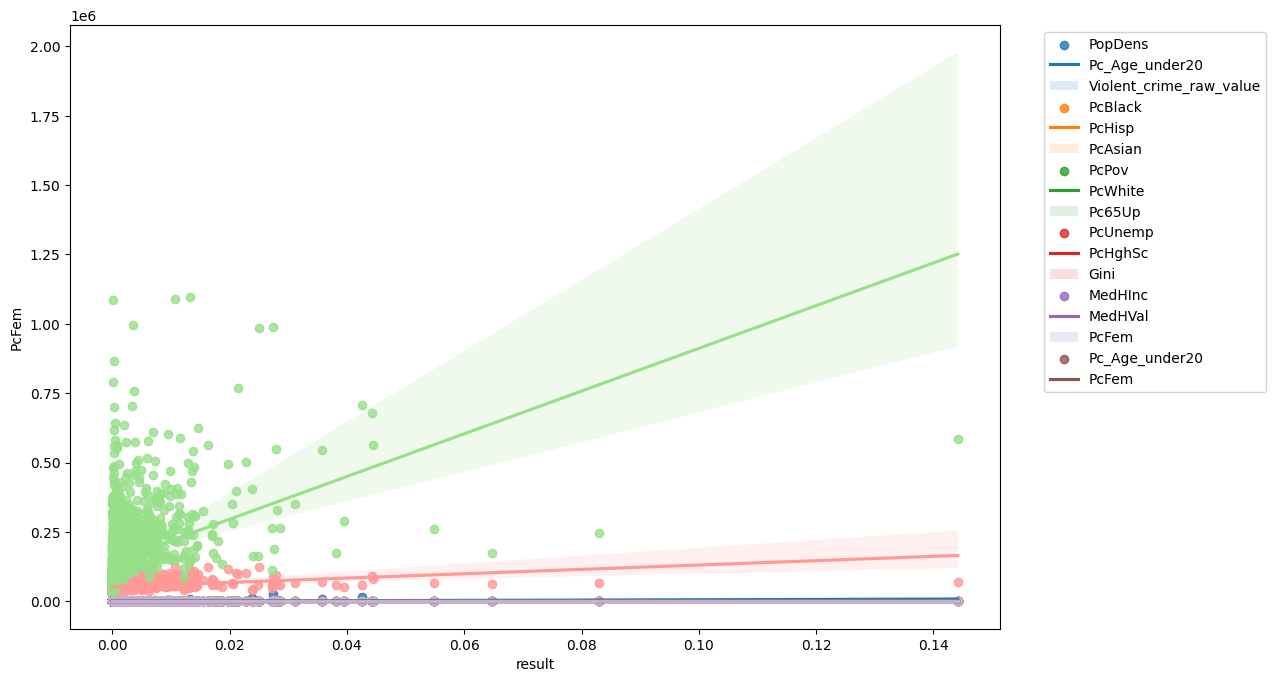

<Figure size 432x288 with 0 Axes>

In [9]:
# plot the regression summary
plt.figure(figsize = (12,8), dpi = 100)
# plot the regression summary
sns.regplot(x='result', y='PopDens', data=df, color='#1f77b4')
sns.regplot(x='result', y='Pc_Age_under20', data=df, color='#ff7f0e')
sns.regplot(x='result', y='Violent_crime_raw_value', data=df, color='#2ca02c')
sns.regplot(x='result', y='PcBlack', data=df, color='#d62728')
sns.regplot(x='result', y='PcHisp', data=df, color='#9467bd')
sns.regplot(x='result', y='PcAsian', data=df, color='#8c564b')
sns.regplot(x='result', y='PcPov', data=df, color='#e377c2')
sns.regplot(x='result', y='PcWhite', data=df, color='#7f7f7f')
sns.regplot(x='result', y='Pc65Up', data=df, color='#bcbd22')
sns.regplot(x='result', y='PcUnemp', data=df, color='#17becf')
sns.regplot(x='result', y='PcHghSc', data=df, color='#7b4173')
sns.regplot(x='result', y='Gini', data=df, color='#a55194')
sns.regplot(x='result', y='MedHInc', data=df, color='#ff9896')
sns.regplot(x='result', y='MedHVal', data=df, color='#98df8a')
sns.regplot(x='result', y='PcFem', data=df, color='#ffbb78')
sns.regplot(x='result', y='Pc_Age_under20', data=df, color='#f7b6d2')
sns.regplot(x='result', y='PcFem', data=df, color='#c5b0d5')

plt.legend(labels=['PopDens', 'Pc_Age_under20', 'Violent_crime_raw_value', 'PcBlack', 'PcHisp', 'PcAsian', 'PcPov', 'PcWhite', 'Pc65Up', 'PcUnemp', 'PcHghSc', 'Gini', 'MedHInc', 'MedHVal', 'PcFem', 'Pc_Age_under20', 'PcFem'],
           bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

# save the plot
plt.savefig('regression.png')

In [ ]:
# set up
options(scipen=999)
df <- read.csv("FeatureTable.csv")
attach(df)
colnames(df)

# run linear regression on selected demographic variables, dependent variable is ESGS index
lm <- lm(result~PopDens + Pc_Age_under20 + Violent_crime_raw_value+
                PcBlack + PcHisp+ PcAsian + PcPov + PcWhite +Pc65Up +
                PcUnemp + PcHghSc +Gini +MedHInc+MedHVal+PcFem+Pc_Age_under20+PcFem, data=df)

summary(lm)
plot(lm,which = 1:2)

# plot the regression summary
install.packages('sjPlot')
library(sjPlot)

q <- plot_models(
  lm,
  m.labels = 'ESGS Index',
  axis.labels = c(
    "Population density",
    "Population under age 20", 
    "Number of Violent crime event", 
    "Black population%",
    "Hispanic population%",
    "Asian population%",
    "Poverty population%",
    "White population%",
    "Population over 65%",
    "Unemloyment population%",
    "High-school degree population%",
    "Gini",
    "Median household income",
    "Median household value",
    "Female population%"),
  colors = "#32543F" ,
  #title = "Demographics and ESGS Index Regression Analysis",
  show.values = TRUE, show.p = TRUE, p.shape = TRUE
)

# save the plot
png(filename="regression.png", width=10, height=6, units = 'in',res=200)
q+theme_sjplot2()
dev.off()


<div>
<img src="https://drive.google.com/uc?id=18e5UToEYm7ruHjHR-Irb4prcKe4DEeHT" width="1000"/>
</div>

# Export to PDF

In [ ]:
# Packages needed to set up the environment
!apt-get update
!apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended pandoc
!pip install nbconvert
!apt-get install texlive-xetex
%cd /content/drive/MyDrive/GSDC

In [29]:
!jupyter nbconvert --to PDF Green*Space*Data*Challenge.ipynb

[NbConvertApp] Converting notebook Green Space Data Challenge.ipynb to PDF
[NbConvertApp] Support files will be in Green Space Data Challenge_files/
[NbConvertApp] Making directory ./Green Space Data Challenge_files
[NbConvertApp] Writing 122224 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 196294 bytes to Green Space Data Challenge.pdf
